In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import matplotlib
# matplotlib.font_manager._rebuild()
# plt.rcParams['font.family'] = 'Times New Roman' #全体のフォントを設定
%matplotlib inline

In [2]:
import sys
sys.path.append("/notebooks/nb_IEEE/opmap/")

In [3]:
import opmap
from opmap.rawCam import RawCam
from opmap.vmemMap import VmemMap
from opmap.apdMap import APDMap
from opmap.phaseMapHilbert import PhaseMapHilbert as PhaseMap
from opmap.phaseVarianceMap import PhaseVarianceMap

In [4]:
def FFT(vmem_1d, N, dt, fc_low=None, fc_high=None):
    fq = np.linspace(0, 1.0/dt, N)
    F = np.fft.fft(vmem_1d)
    if fc_low is not None:
        F[(fq <= fc_low)] = 0
    if fc_high is not None:
        F[(fq >= fc_high)] = 0
    
    F_abs = np.abs(F)
    F_abs_amp = F_abs/N
#     F_abs_amp[0] = F_abs_amp[0]/2
    F_abs_amp[0] = 0
    
    F_ifft = np.fft.ifft(F)
    F_ifft_real = F_ifft.real * 2
    
    return F_ifft_real

In [5]:
def isochronal(pmap, threshold):
    contour = np.zeros_like(pmap.data)

    for i in range(contour.shape[1]):
        for j in range(contour.shape[2]):        
            if pmap.roi[i,j] == 1:
                counter = 0
                for time in range(contour.shape[0]):
                    if time == 0:
                        pass
                    elif ((pmap.data[time-1, i, j] < threshold) * (pmap.data[time, i, j] > threshold)) == 1:
                        counter = 0

                    contour[time, i, j] = counter
                    counter += 1
                
    return contour

## 旋回興奮に対する冷却

In [6]:
import cv2

### 20181220-1/C001H001S0012

In [7]:
parent_path = '/mnt/Jalife/ExperimentData/'

data_path = os.path.join(parent_path, '20181220-1/C001H001S0012/')
print(data_path)
start = 9500
end = 11000
date = data_path.split('/')[-3]
session_name = data_path.split('/')[-2]
save_parent = os.path.join('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/', '%s/%s/%s-%s' % (date, session_name, start, end))

raw = RawCam(path=data_path, cam_type='sa4',
          image_width=256, image_height=256, frame_start=start, frame_end=end)

vmem = VmemMap(raw)

roi_png = cv2.imread('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0012/9500-11000/ROI.png', cv2.IMREAD_GRAYSCALE)
roi_png = roi_png/255.0

vmem.roi = roi_png
vmem.data = vmem.data * vmem.roi

for i in range(vmem.data.shape[1]):
    for j in range(vmem.data.shape[2]):
        vmem.data[:, i, j] = FFT(vmem.data[:, i, j], vmem.data.shape[0], 0.002, fc_low=2, fc_high=48)

vmem.smooth(size=9)

/mnt/Jalife/ExperimentData/20181220-1/C001H001S0012/


In [174]:
import scipy

def vmem_denoise(vmem):
#     data = scipy.ndimage.filters.gaussian_filter1d(vmem, sigma=1)
    data = vmem
    return (data-np.min(data))/(np.max(data)-np.min(data))

In [176]:
plt.subplot(4,1,1)
plt.plot(vmem_denoise(vmem.data[350:430, 40, 60]))
plt.xticks([])
plt.yticks([0, 0.25, 0.5, 0.75, 1.0])
plt.ylim([-0.1, 1.1])

plt.subplot(4,1,2)
plt.plot(vmem_denoise(vmem.data[350:430, 60, 90]))
plt.xticks([])
plt.yticks([0, 0.25, 0.5, 0.75, 1.0])
plt.ylim([-0.1, 1.1])

plt.subplot(4,1,3)
plt.plot(vmem_denoise(vmem.data[350:430, 80, 120]))
plt.xticks([])
plt.yticks([0, 0.25, 0.5, 0.75, 1.0])
plt.ylim([-0.1, 1.1])

plt.subplot(4,1,4)
plt.plot(vmem_denoise(vmem.data[350:430, 100, 150]))
plt.xticks([10, 30, 50, 70], [20.7, 20.74, 20.78, 20.82])
plt.yticks([0, 0.25, 0.5, 0.75, 1.0])
plt.ylim([-0.1, 1.1])

plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0012/9500-11000/vmem_comparizon.png')
plt.close()

In [8]:
pmap = PhaseMap(vmem)

In [9]:
import copy

for i in range(500):
    dat = copy.deepcopy(pmap.data[i]) - 1
    dat = dat +(dat < -np.pi)*2*np.pi

    pmap.data[i] = dat * pmap.roi

(450, 470)

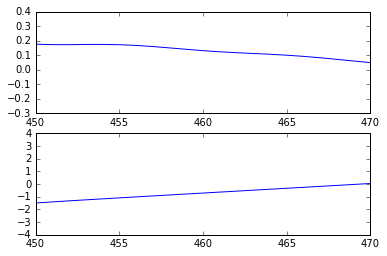

In [84]:
plt.subplot(2,1,1)
plt.plot(vmem.data[:, 128, 128])
plt.xlim([450, 470])
plt.subplot(2,1,2)
plt.plot(pmap.data[:, 64,64])
plt.xlim([450, 470])

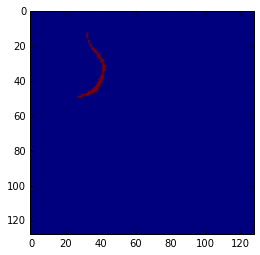

In [85]:
time = 390
dt = 3
plt.imshow((pmap.data[time-dt] < -3)*(pmap.data[time+dt]>-3))

In [126]:
for d in range(5):
    time = 390 + d
    dt = 5
#     WF = (pmap.data[time-dt]<-3)*(pmap.data[time+dt]>-3)
    WF = (pmap.data[time] > 2.9) * 1
    
    im_rgb = Image.open('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0012/9500-11000/trajectory.png')
    im_rgba = im_rgb.copy()
    im_rgba.putalpha(128)
    im_data = np.array(im_rgba)

    for i in range(128):
        for j in range(128):
            im_data[i,j,0] = 0
            im_data[i,j,1] = 0
            im_data[i,j,2] = 0
            if WF[i,j] < 0.5:
                im_data[i,j,3] = 0
            else:
                im_data[i,j,0] = 255
                im_data[i,j,3] = 255
    plt.imsave('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0012/9500-11000/jet/wavefront/%s.png'%d, im_data)
    plt.close()

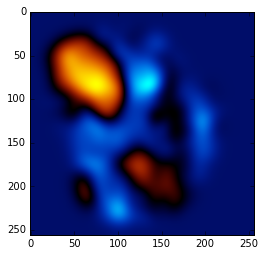

In [104]:
plt.imshow(vmem.data[time], cmap=vmem.cmap)

In [22]:
isochronal_data = isochronal(pmap, 2.9)

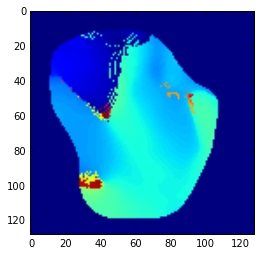

In [47]:
plt.imshow(isochronal_data[895])

In [49]:
from scipy import ndimage
import copy
import scipy

In [50]:
data = copy.deepcopy(isochronal_data[900])
data = ndimage.gaussian_filter(data, 3) * pmap.roi
data = scipy.signal.medfilt2d(data, 19) * pmap.roi

In [52]:
x = np.arange(0, 128, 1)
y = np.arange(0, 128, 1)

In [55]:
xx, yy = np.meshgrid(x, y)

In [90]:
np.arange(15,51,1)

array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
       32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
       49, 50])

In [100]:
# plt.contour(xx, yy, data[::-1], cmap='viridis', levels=[15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50])
plt.contour(xx, yy, data[::-1], cmap='viridis', levels=np.arange(10,61,1))
plt.gca().set_aspect('equal')
plt.xticks([])
plt.yticks([])
plt.savefig('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0012/9500-11000/contour.png')
plt.close()

In [78]:
for i in range(5):
    plt.imsave('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0012/vmem_snapshot/%s.png'%i, vmem.data[891+i], vmin=-0.1, vmax=0.1, cmap='hot')
    plt.close()

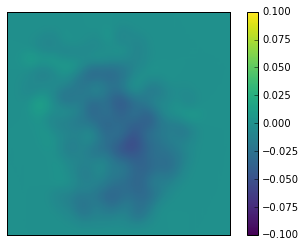

In [10]:
plt.imshow(vmem.data[1165], cmap='viridis', vmin=-0.1, vmax=0.1)
plt.xticks([])
plt.yticks([])
plt.colorbar()

In [76]:
plt.imsave('/mnt/Omer/Project/03.LinearRegionalCooling/AnalysisResult/Experiment/IEEE/20181220-1/C001H001S0012/vmem_snapshot/terminate.png', vmem.data[1165], vmin=-0.1, vmax=0.1, cmap='hot')
plt.close()